## 001 Simple Analysis Tooling

This run is a clone of #002. The main difference is that this run was used to develop tools for analyzing the results of a 
models predictions.

In [39]:
import sys
sys.path.append('../')
sys.path.append('../../../')
# keras expects data to be encoded in a particular way, to_categorical does this encoding for us (one-hot encoding)
from keras.utils.np_utils import to_categorical
import libs.importing as importing
import pandas as pd
import os
import libs.render as render 
import models
import libs.analysis as analysis
import libs.normalization as normalization
from importlib import reload
import libs.data_prep as data_prep
import numpy as np

from pylab import rcParams
rcParams['figure.figsize'] = (12,10)

In [217]:
# LOAD PATCH DATA REFERENCES
reload(importing)
# directory setup
data_source = '../6ceac90d'
train_dir = os.path.join(data_source, 'train')
test_dir = os.path.join(data_source, 'test')
val_dir = os.path.join(data_source, 'val')

# get references to the data we want
train_patches_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned_shuffled.csv'))
train_data_reader = importing.PatchDataReader(os.path.join(train_dir, 'patches'), train_patches_df)

test_patches_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned_shuffled.csv'))
test_data_reader = importing.PatchDataReader(os.path.join(test_dir, 'patches'), test_patches_df)

val_patches_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned_shuffled.csv'))
val_data_reader = importing.PatchDataReader(os.path.join(val_dir, 'patches'), val_patches_df)

In [33]:
# load train, test, and validation data
reload(importing)
x_train, y_train = train_data_reader.read_data()
x_test, y_test = test_data_reader.read_data()
x_val, y_val = val_data_reader.read_data()

In [56]:
## READ PATCH DATA
reload(data_prep)

# LOG RESULTS
## Visualize the patches
data_prep.log_patch_data_reader2(train_dir, train_data_reader)
data_prep.log_patch_data_reader2(test_dir, test_data_reader)
data_prep.log_patch_data_reader2(val_dir, val_data_reader)

In [57]:
## CONVERT CLASSES TO KERAS FORMAT
# keras expects classes to be number from 0-N, we are using 1-N numbering so we need to convert.
# then we also have to change the classes to one-hot encoding

y_train_oh = to_categorical(y_train - 1)
y_test_oh  = to_categorical(y_test - 1)
y_val_oh   = to_categorical(y_val - 1)

In [58]:
# NORMALIZATION

m, std = normalization.dataset_mean_and_std(x_train)

x_train = (x_train - m) / std
x_test  = (x_test - m) / std
x_val   = (x_val - m) / std

In [59]:
## MODEL : load from file, show summary, and compile
reload(models)

model = models.run_002_added_dropout()
display(model.summary())

# parameters:
learning_rate = 1e-3

model.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        18496     
__________

None

In [60]:
reload(data_prep)

data_prep.check_for_nans(x_train)
data_prep.check_for_nans(x_test)
data_prep.check_for_nans(x_val)

print(y_train[:100], y_test[:100], y_val[:100])

[1 1 2 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 2 1 2 2 1 2 1 1 1 2 1 1 1 1 2 1 1 1 1 2
 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1] [2 2 1 2 2 2 1 1 1 2 2 2 2 1 2 1 2 2 2 1 1 1 1 2 1 2 2 1 1 1 2 2 2 1 2 2 1
 2 2 2 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 1 2 2 1 2 2 2 2 1 2 2 1 1 2 2 1 2 1 2
 2 2 2 1 2 1 1 2 2 1 2 1 2 1 2 2 2 2 2 1 2 1 1 1 2 1] [2 2 2 1 2 1 2 1 1 2 2 1 2 1 2 2 2 2 2 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1
 2 1 2 1 2 1 2 2 2 2 2 1 2 2 2 1 2 2 1 2 1 2 1 1 2 1 1 2 2 1 2 2 2 1 2 2 2
 1 1 1 1 2 2 1 1 2 1 1 2 2 1 2 2 2 1 1 2 1 1 1 1 2 1]


In [61]:
## RUN!!!

# parameters
batch_size = 16
epochs = 7

history = model.fit(x_train,y_train_oh, batch_size=batch_size,
                              epochs = epochs,
                              validation_data = (x_test,y_test_oh), shuffle=True,
                              verbose = 1, callbacks=[models.annealer()])

Train on 891 samples, validate on 298 samples
Epoch 1/7
891/891 [==============================] - 35s 39ms/step - loss: 0.3676 - acc: 0.8474 - val_loss: 0.5327 - val_acc: 0.8020
Epoch 2/7
891/891 [==============================] - 33s 37ms/step - loss: 0.2661 - acc: 0.8911 - val_loss: 0.7769 - val_acc: 0.8104
Epoch 3/7
891/891 [==============================] - 33s 37ms/step - loss: 0.2533 - acc: 0.9012 - val_loss: 0.7930 - val_acc: 0.8557
Epoch 4/7
891/891 [==============================] - 33s 37ms/step - loss: 0.2253 - acc: 0.9097 - val_loss: 0.8598 - val_acc: 0.8037
Epoch 5/7
891/891 [==============================] - 33s 37ms/step - loss: 0.2190 - acc: 0.9147 - val_loss: 0.6139 - val_acc: 0.8356
Epoch 6/7
891/891 [==============================] - 33s 37ms/step - loss: 0.2185 - acc: 0.9153 - val_loss: 0.8458 - val_acc: 0.8473
Epoch 7/7
891/891 [==============================] - 33s 37ms/step - loss: 0.2014 - acc: 0.9209 - val_loss: 0.8451 - val_acc: 0.8070

Epoch 00007: ReduceLRO

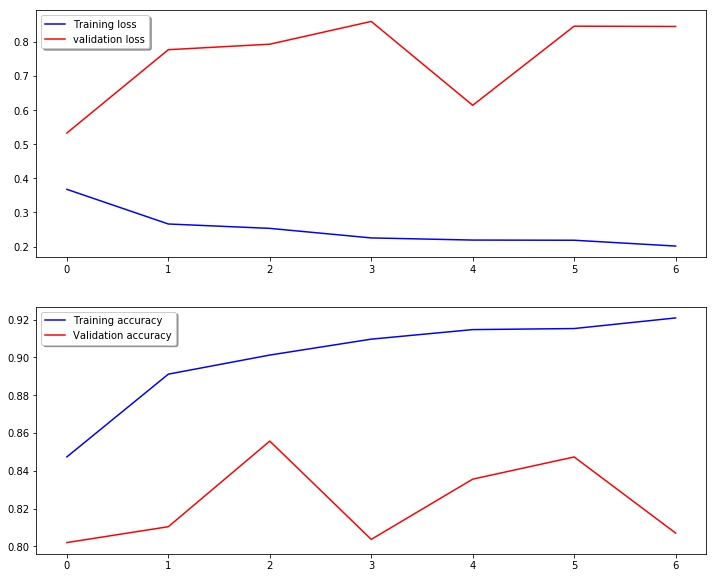

Precision (specificity): 81.319%
Recall (sensitivity): 65.772%
Accuracy: 68.125%
F1: 62.493%


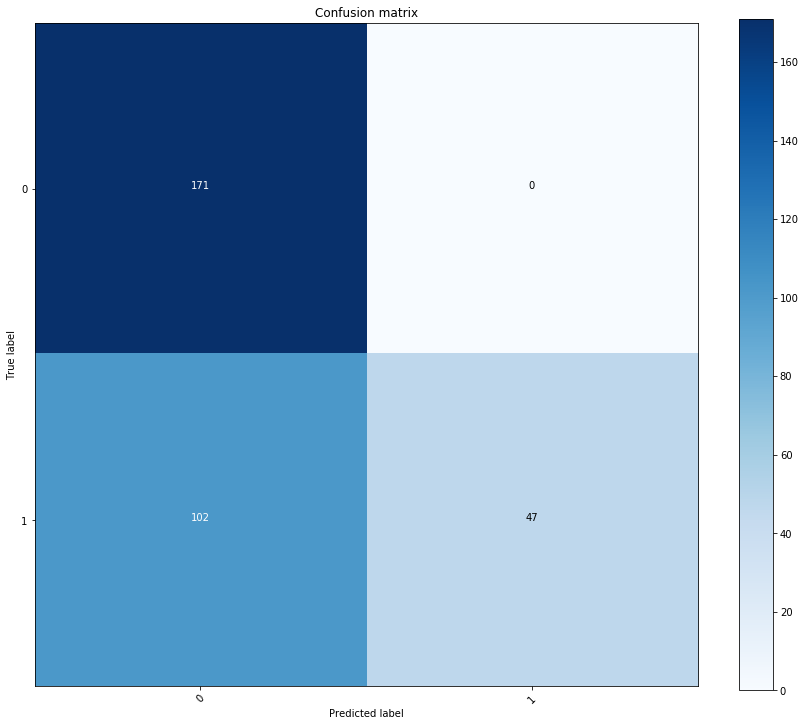

In [62]:
render.plot_training_and_validation_curves(history)

y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [142]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(test_data_reader, model, test_dir, norm_data=(m, std))

In [141]:
reload(analysis)
analysis.contour_statistics(test_data_reader, model, test_dir, norm_data=(m, std))

odi-b43ee406 [0.07019808 0.9365028 ] 0
mdi-461bdebc [9.9999970e-01 2.4216834e-07] 0
hgv-2cdb69f6 [0.30547372 0.7103663 ] 1
hgv-99fc12a1 [0.5643318  0.44755286] 1
hgv-99fc12a1 [0.7337993  0.27638265] 1
mdi-df9a656f [0.9790712  0.02011534] 0


In [143]:
## Save the model : so we can load it later
model.save('./run_003_m1.h5')

1


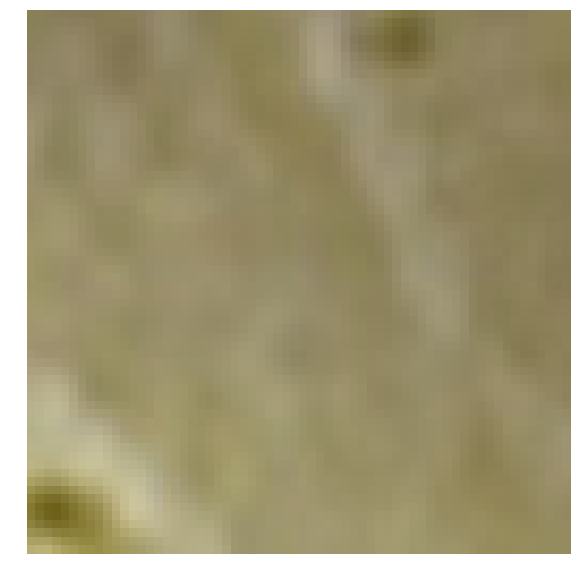

Shape of conv: (16, 16, 64)


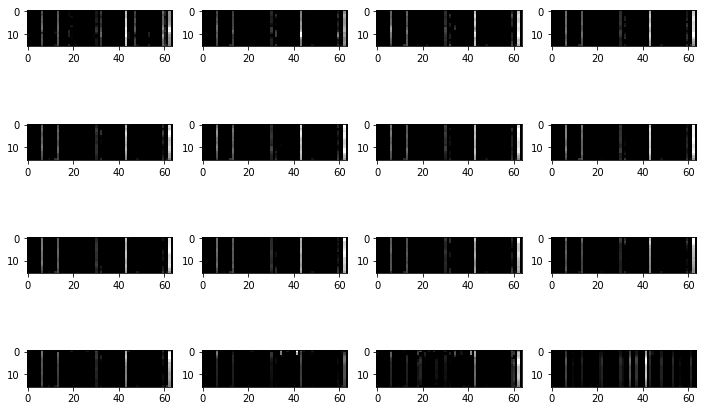

In [230]:
## Visualize the learned filters
import libs.visualize_filters as vf
import libs.render as render
reload(vf)


#model.summary()
#vf.visualize_filters(model, output_layer='dense_4', filter_idx=1) # papillomas
#vf.visualize_filters(model, output_layer='dense_4', filter_idx=0) # benign

#val_data_reader.read_data()
#img = val_data_reader.get_images()[108]
#print(val_data_reader.get_labels()[108])

#render.plot_image( img )
#out_layer = model.layers[11]

#vf.plot_saliency(model, out_layer, (img - m) / std )

In [12]:
## Second RUN!!! : increase the epochs to 15

history2 = model.fit(x_train,y_train_oh, batch_size=16,
                              epochs = 10,
                              validation_data = (x_test,y_test_oh), shuffle=True,
                              verbose = 1, callbacks=[models.annealer()])

Train on 891 samples, validate on 298 samples
Epoch 1/10
891/891 [==============================] - 53s 59ms/step - loss: 0.2113 - acc: 0.9153 - val_loss: 1.0474 - val_acc: 0.8691
Epoch 2/10
891/891 [==============================] - 52s 58ms/step - loss: 0.1912 - acc: 0.9259 - val_loss: 1.1411 - val_acc: 0.8372
Epoch 3/10
891/891 [==============================] - 52s 58ms/step - loss: 0.1871 - acc: 0.9287 - val_loss: 0.9044 - val_acc: 0.8574
Epoch 4/10
891/891 [==============================] - 56s 63ms/step - loss: 0.1795 - acc: 0.9276 - val_loss: 1.4158 - val_acc: 0.7919
Epoch 5/10
891/891 [==============================] - 52s 59ms/step - loss: 0.1646 - acc: 0.9355 - val_loss: 1.1184 - val_acc: 0.8591

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/10
891/891 [==============================] - 51s 57ms/step - loss: 0.1395 - acc: 0.9439 - val_loss: 1.4456 - val_acc: 0.8138
Epoch 7/10
891/891 [==============================] - 61s 68ms/step -

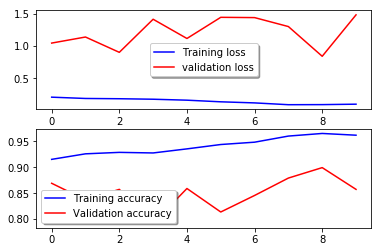

Precision (specificity): 72.451%
Recall (sensitivity): 66.041%
Accuracy: 67.812%
F1: 64.556%


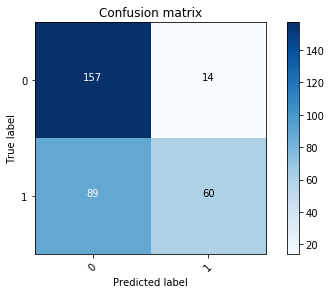

In [13]:
render.plot_training_and_validation_curves(history2)

y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)